In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

In [2]:
from tools.pid import PID
from tools.motor import DC_Motor as Motor
import math
import matplotlib.pyplot as plt

## Step Response

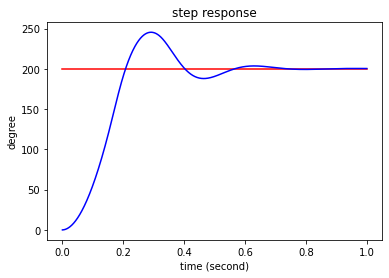

In [3]:
motor = Motor()
#pid = PID(10, 0.1, 1)
#pid = PID(10, 0.1, 0.5)
pid = PID(10, 0.1, 0.3)
target = 200
targetR = target * math.pi / 180
import matplotlib.pyplot as plt
yTarget = []
yResponse = []
xTime = []

# Create data
for millisecond in range(1000):
    theta = motor.getRad()
    controlSignal = pid.update(targetR - theta)
    motor.update(controlSignal)
    
    xTime += [millisecond / 1000]
    yResponse += [motor.getAngle()]
    yTarget += [target]

# draw graph
plt.plot(xTime, yTarget, color='r', label='target')
plt.plot(xTime, yResponse, color='b', label='response')
plt.title('step response')
plt.ylabel('degree')
plt.xlabel('time (second)')
plt.show()

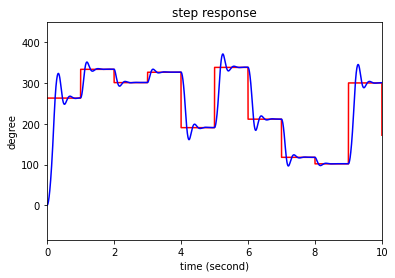

In [4]:
import json
with open('data.json') as json_file:
    data = json.load(json_file)
    
motor = Motor()
#pid = PID(10, 0.1, 1)
#pid = PID(10, 0.1, 0.5)
pid = PID(10, 0.1, 0.3)

yTarget = []
yResponse = []
xTime = []
xError = []
ySignal = []

# Create data
steps = data['target']
time = 0
for i in range(len(steps)):
    target = steps[i]
    targetR = target * math.pi / 180
    
    for millisecond in range(1000):
        time += 1
        theta = motor.getRad()
        controlSignal = pid.update(targetR - theta)
        motor.update(controlSignal)
    
        ySignal += [controlSignal]
        xError += [targetR - theta]
        xTime += [time / 1000]
        yResponse += [motor.getAngle()]
        yTarget += [target]
    
# draw graph
plt.plot(xTime, yTarget, color='r', label='target')
plt.plot(xTime, yResponse, color='b', label='response')
plt.xlim(0, 10)
plt.title('step response')
plt.ylabel('degree')
plt.xlabel('time (second)')
plt.show()

## Relationshiop between error and control signal

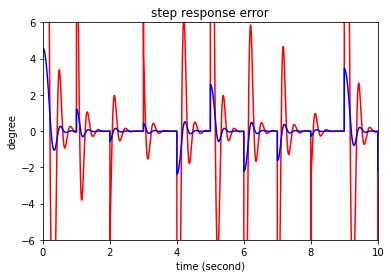

In [5]:
plt.plot(xTime, ySignal, color='r', label='target')
plt.plot(xTime, xError, color='b', label='error')
plt.xlim(0, 10)
plt.title('step response error')
plt.ylabel('degree')
plt.xlabel('time (second)')
plt.ylim(-6, 6)
plt.show()

In [6]:
df = pd.DataFrame()
df['error'] = xError
df['signal'] = ySignal

_x = df[['error']].values
_y = df[['signal']].values

scalar_x = MinMaxScaler()
scalar_y = MinMaxScaler()
x = scalar_x.fit_transform(_x)
y = scalar_y.fit_transform(_y)

In [7]:
x

array([[0.90234101],
       [0.90233121],
       [0.90229951],
       ...,
       [0.49877768],
       [0.49877625],
       [0.49877484]])

In [8]:
# Hyperparameters for model
window = 15
layers = 2
batch_size = 100
drop = 0.1
units = 100

In [9]:
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(x[i-window:i])
    y_lstm.append(y[i])
    
# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
xTrain, xTest, yTrain, yTest = train_test_split(X_lstm,y_lstm,test_size=0.2,shuffle=False)

## Training LSTM Model

In [10]:
# Keras LSTM model
model = Sequential()

# First layer specifies input_shape and returns sequences
model.add(
    LSTM(
        units=units,
        return_sequences=True,
        input_shape=(xTrain.shape[1], xTrain.shape[2])
    )
)
model.add(Dropout(rate=drop))

# Middle layers return sequences
for i in range(layers-2):
    model.add(LSTM(units=units,return_sequences=True))
    model.add(Dropout(rate=drop))
# Last layer doesn't return anything
model.add(LSTM(units=units))
model.add(Dropout(rate=drop))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=25
                  )

result = model.fit(xTrain, yTrain, 
                   verbose=0, 
                   validation_split=0.2,
                   callbacks = [es,TqdmCallback(verbose=1)],
                   batch_size=batch_size,
                   epochs=350)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00105: early stopping


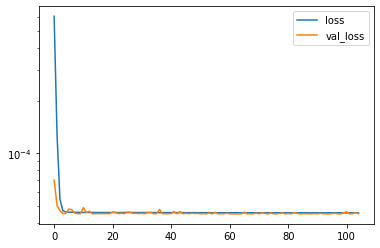

In [11]:
# Show results and save
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('./model/pid_model.h5')

In [12]:
yPredict = model.predict(xTest)

In [13]:
yPredictR = scalar_y.inverse_transform(yPredict)
yTestR = scalar_y.inverse_transform(yTest)

(0.495, 0.505)

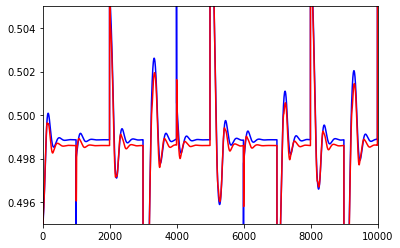

In [14]:
plt.plot(yTest, 'b')
plt.plot(yPredict, 'r')
plt.xlim(0, 10000)
plt.ylim(0.495, 0.505)

In [15]:
history = []
for i in range(15):
    history += [[0]]
history = np.array([history])

def lstm_pid (error):
    global history
    error = scalar_x.transform([[error]])[0, 0]
    history = np.array([history[0][1:].tolist() + [[error]]])
    ys = model.predict(history)
    return scalar_y.inverse_transform(ys)[0, 0]

In [16]:
import json
import time
with open('data.json') as json_file:
    data = json.load(json_file)
    
motor = Motor()
lstm_response = []

# Create data
steps = data['target']
timeStart = time.time()
for i in range(10):
    target = steps[i]
    targetR = target * math.pi / 180
    print(i)
    for millisecond in range(1000):
        #time += 1
        theta = motor.getRad()
        controlSignal = lstm_pid(targetR - theta)
        #print(controlSignal)
        motor.update(controlSignal)
        
        lstm_response += [motor.getAngle()]
timeEnd = time.time()

0
1
2
3
4
5
6
7
8
9


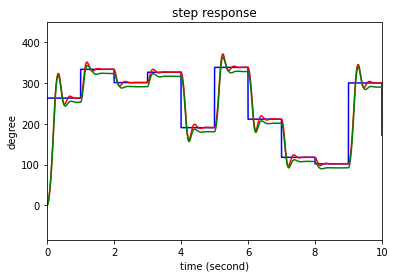

In [17]:
# draw graph
plt.plot(xTime, yTarget, color='b', label='target')
plt.plot(xTime, yResponse, color='r', label='response')
plt.plot(xTime[:10000],lstm_response, color='g', label='response')
plt.xlim(0, 10)
plt.title('step response')
plt.ylabel('degree')
plt.xlabel('time (second)')
plt.show()

In [18]:
tmp = dict()
tmp['scalar_x'] = scalar_x
tmp['scalar_y'] = scalar_y
tmp['window'] = window
pickle.dump(tmp, open('./model/model_params.pkl', 'wb'))